In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.text as mtext
from matplotlib.colors import TwoSlopeNorm
import textwrap
from core import med_log_odds_cutoff, bw_color_palette
import numpy as np
from tqdm import tqdm

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
def assign_hit_category(row, qcov=0.4):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > qcov:
        return 'Remote defense homolog'
    elif row['foldseek_q_cov'] > qcov:
        return 'Structural defense homolog'
    else:
        return 'Predicted novel defense gene'

In [9]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    filt_df = hhblits_df[(hhblits_df['Prob'] > prob_cutoff)]
    for group, group_df in tqdm(filt_df.groupby('query'), 
                                position=0, total=filt_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [3]:
search_df = pd.read_table('../data3/interim/refseq1k_put_novel_rep_search.txt',
                          names=["query", "target", "fident", "alnlen", "mismatch", "gapopen", "qstart", "qend", "tstart", "tend", "qcov", "tcov", "evalue", "bits", "alntmscore", "qtmscore", "ttmscore", "rmsd", "lddt", "prob"])
predictions = pd.read_parquet('../data3/interim/refseq1k_predicted_defense.pq')
hhpred_results = pd.read_csv('../data3/interim/refseq_1k_putative_novel_pfam_df_domains.csv')
blacklisted_domains = pd.read_csv('../data3/interim/df_blacklisted_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])


In [7]:
og_predictions = pd.read_parquet('../data3/processed/refseq_1k_predictions.pq')

In [8]:
clusters = pd.read_parquet('../data3/interim/refseq_cover_clusters.pq')

In [9]:
cluster_size = (clusters['cluster_id']
                .value_counts()
                .reset_index()
                .rename(columns={'count': 'cluster_size'}))

In [10]:
#og_pfam = pd.read_csv('../data3/external/redfseq1k_putative_novel_pfam_annot_v1.csv')

In [11]:
top_search_df = (search_df.sort_values('prob', ascending=False)
                 .groupby('query')
                 .head(1))

In [12]:
homolog_df = (top_search_df[top_search_df['prob'] > 0.6]
              .reset_index(drop=True))

In [13]:
merged_predictions = (predictions
                      .merge(homolog_df
                             .rename(columns={'query': 'product_accession',
                                              'target': 'foldseek_hit',
                                              'prob': 'foldseek_prob',
                                              'qcov': 'foldseek_q_cov'}), 
                             how='left', on='product_accession'))
merged_predictions['foldseek_q_cov'] = merged_predictions['foldseek_q_cov'].fillna(0)

In [14]:
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Structural defense homolog',
                  'Predicted novel defense gene']
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=hit_categories)

In [15]:
merged_predictions['hit_category'].value_counts()

hit_category
Predicted novel defense gene          5204
Remote defense homolog                3541
Defense homolog in expected system    3448
Defense homolog in new context        2706
Structural defense homolog             925
Name: count, dtype: int64

In [16]:
((merged_predictions['hit_category'] == 'Predicted novel defense gene') & 
 (merged_predictions['q_cov'] == 0) & 
 (merged_predictions['foldseek_q_cov'] == 0)).sum()

3140

In [17]:
genomes = og_predictions['assembly'].drop_duplicates()
len(genomes)

999

In [18]:
n_boot = 10

In [19]:
sample_range = [int(x) for x in np.linspace(1, len(genomes), num=50)]
n_def_cluster_list = list()
for n in tqdm(sample_range):
    for boot in range(n_boot):
        sampled_genomes = set(genomes.sample(n=n, random_state=boot))
        sampled_clusters = set(og_predictions.loc[og_predictions['assembly'].isin(sampled_genomes), 'cluster_id'])
        sampled_def_df = merged_predictions[merged_predictions['cluster_id'].isin(sampled_clusters)]
        n_def_clusters = (sampled_def_df['hit_category']
                          .value_counts()
                          .reset_index())
        n_def_clusters['n_genomes'] = n
        n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [05:21<00:00,  6.42s/it]


In [20]:
agg_n_def_cluster = (cat_n_def_cluster.groupby(['hit_category', 'n_genomes'])
                     .agg({'count': 'mean'})
                     .reset_index())

In [21]:
agg_n_def_cluster['hit_category'] = pd.Categorical(agg_n_def_cluster['hit_category'], 
                                                         categories=hit_categories)

In [22]:
color_palette = sns.color_palette(['#e69f00', '#56b4e9', '#009e73', '#0072b2','#f0e442'])

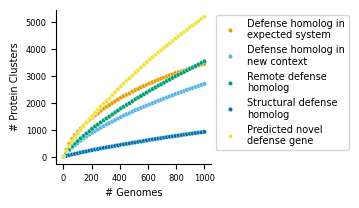

In [23]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='hit_category',
              palette=color_palette, s=10)
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.savefig('../figures/refseq1k_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

In [24]:
merged_predictions.to_parquet('../data3/interim/refseq1k_predicted_defense2.pq')

## Get new domains

In [4]:
merged_predictions = pd.read_parquet('../data3/interim/refseq1k_predicted_defense2.pq')

In [5]:
novel_accs = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene',
                                    'product_accession']

In [6]:
len(novel_accs)

5204

In [7]:
pfam_hhpred_results = hhpred_results[hhpred_results['hit_name'].str.startswith('PF') & 
                                     hhpred_results['query'].isin(novel_accs)]

In [10]:
select_pfam = select_domains(pfam_hhpred_results)

  0%|          | 0/3659 [00:00<?, ?it/s]

100%|██████████| 3659/3659 [00:01<00:00, 2015.22it/s]


In [11]:
select_pfam['pfam_id'] = select_pfam['hit_name'].str.split('.', expand=True)[0]
select_pfam = select_pfam.merge(pfam_clans, how='inner', on='pfam_id')

In [30]:
filtered_pfam = select_pfam[~select_pfam['pfam_id'].isin(blacklisted_domains['pfam_id'].unique()) & 
                            ~select_pfam['clan_id'].isin(blacklisted_domains['clan_id'].dropna().unique())]

In [31]:
filtered_pfam['pfam_id'].nunique()

570

In [38]:
filtered_pfam.loc[filtered_pfam['hit_name'].str.contains('Cas'), :]

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,pfam_id,clan_id,clan_name,pfam_name,pfam_description
4801,PF18061.4 ; CRISPR_Cas9_WED ;,99.9,0.0,0.0,181.8,0.0,124.0,22-146,1-131 (132),WP_142090744.1,22.0,146.0,PF18061.4 ; CRISPR_Cas9_WED ; CRISPR-Cas9 WED ...,PF18061,NaN,NaN,CRISPR_Cas9_WED,CRISPR-Cas9 WED domain
4802,PF18070.4 ; Cas9_PI2 ; CRISPR-,98.9,0.0,0.0,88.2,0.0,57.0,151-207,1-59 (59),WP_142090744.1,151.0,207.0,PF18070.4 ; Cas9_PI2 ; CRISPR-Cas9 PI domain,PF18070,NaN,NaN,Cas9_PI2,CRISPR-Cas9 PI domain


In [32]:
filtered_pfam.loc[filtered_pfam['hit_name'].str.contains('DUF'), 'pfam_id'].nunique()

244

In [33]:
filtered_pfam.loc[filtered_pfam['hit_name'].str.contains('imm'), :]

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,pfam_id,clan_id,clan_name,pfam_name,pfam_description
4424,PF18616.4 ; CdiI_3 ; CDI immun,99.9,0.0,0.0,192.6,0.0,94.0,112-206,1-95 (95),WP_105620020.1,112.0,206.0,PF18616.4 ; CdiI_3 ; CDI immunity proteins,PF18616,NaN,NaN,CdiI_3,CDI immunity proteins
5018,PF18624.4 ; CdiI_4 ; CDI immun,99.9,0.0,0.0,170.1,0.0,100.0,14-120,1-104 (104),WP_185639269.1,14.0,120.0,PF18624.4 ; CdiI_4 ; CDI immunity protein,PF18624,NaN,NaN,CdiI_4,CDI immunity protein
5035,PF07262.14 ; CdiI ; CDI immuni,97.8,0.0,0.0,65.2,0.0,138.0,2-140,2-155 (155),WP_190329033.1,2.0,140.0,PF07262.14 ; CdiI ; CDI immunity protein,PF07262,NaN,NaN,CdiI,CDI immunity protein


In [34]:
filtered_pfam.shape

(1686, 18)

In [35]:
merged_pfam = (filtered_pfam.rename(columns={'query': 'product_accession'})
               .merge(merged_predictions, how='inner', on='product_accession', 
                      suffixes=('_Pfam', '_DF'))
               .merge(cluster_size, how='inner', on='cluster_id'))
merged_pfam['hhblits_rank_pfam'] = merged_pfam['Prob_Pfam'].rank(pct=True)
merged_pfam['pred_rank'] = merged_pfam['mean_log_odds'].rank(pct=True)
merged_pfam['cluster_rank'] = merged_pfam['cluster_size'].rank(pct=True)
merged_pfam['hhblits_rank_df'] = merged_pfam['q_cov'].rank(pct=True, ascending=False)
merged_pfam['foldseek_rank'] = merged_pfam['foldseek_q_cov'].rank(pct=True, ascending=False)
merged_pfam['mean_rank'] = merged_pfam[['hhblits_rank_pfam', 'pred_rank',
                                        'cluster_rank', 'hhblits_rank_df',
                                        'foldseek_rank']].mean(axis=1)

In [36]:
unique_merged_pfam = (merged_pfam.sort_values('mean_rank', ascending=False)
                      .groupby('pfam_id')
                      .head(1))

In [37]:
unique_merged_pfam.to_csv('../data3/interim/candidate_refseq_pfams.csv', index=False)

In [38]:
annot_v1 = pd.read_csv('../data3/external/candidate_refseq_pfams_annot_v1.csv')
annot_v1['highlight'] = annot_v1['highlight'].fillna(False)

In [31]:
n_neighbors = 5

In [32]:
predictions['mean_log_odds'].min()

4.001110882867033

In [33]:
norm = TwoSlopeNorm(vmin=og_predictions['mean_log_odds'].min(), 
                    vcenter=0, 
                    vmax=og_predictions['mean_log_odds'].max())
cmap = plt.get_cmap('RdBu_r')

In [34]:
sorted_predictions = (og_predictions.sort_values(['genomic_accession', 
                                               'start'], ascending=False)
                      .reset_index(drop=True))

In [ ]:
highlight_v1 = annot_v1.query('highlight')

In [40]:
for _, hit in highlight_v1.iterrows():
    title = '\n'.join([hit['protein_context_id'], f"Log-odds: {str(hit['mean_log_odds'])}", 
                       hit["pfam_name"], f"Prob: {str(hit['Prob_Pfam'])}"])
    center_row = sorted_predictions.loc[sorted_predictions['protein_context_id'] == hit['protein_context_id'], :].squeeze()
    neighbor_df = sorted_predictions.iloc[(center_row.name - n_neighbors):(center_row.name + n_neighbors + 1), :]
    neighbor_df = neighbor_df[neighbor_df['genomic_accession'] == center_row['genomic_accession']]
    min_start = neighbor_df['start'].min()
    max_end = neighbor_df['end'].max()
    features = list()
    for _, gene in neighbor_df.iterrows():
        start = gene['start'] - min_start
        end = gene['end'] - min_start
        if gene['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if (gene['protein_context_id'] == center_row['protein_context_id']):
            linecolor = 'red'
        else:
            linecolor = 'black'
        if gene['defense_system_protein']:
            label = gene['defense_system_gene']
        elif gene['defense_homolog']:
            if gene['name'] != 'hypothetical protein':
                label = f"{gene['name']} ({gene['defense_homolog_name']})"
            else:
                label = gene['defense_homolog_name']
        elif gene['name'] == 'hypothetical protein':
            label = None
        else:
            label = gene['name']
        color = cmap(norm(gene['mean_log_odds']))
        feature = GraphicFeature(start=start, end=end, strand=strand, linecolor=linecolor, 
                                 label=label, color=color, linewidth=2)
        features.append(feature)
    record = GraphicRecord(sequence_length=(max_end - min_start + 1), features=features)
    _, ax = plt.subplots(figsize=(8, 5))
    record.plot(ax=ax)
    plt.subplots_adjust(bottom=0)
    plt.title(title)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='Log-odds of defense)', ax=ax, location='bottom', shrink=0.25)
    plt.show()

## Old code

In [39]:
no_pfam_hits = (merged_predictions[(merged_predictions['hit_category'] == 'Predicted novel defense gene') & 
                                   (~merged_predictions['product_accession'].isin(select_pfam['query'])) &
                                   (merged_predictions['q_cov'] == 0)]
                .merge(cluster_size, how='inner', on='cluster_id'))
no_pfam_hits['cluster_size_rank'] = no_pfam_hits['cluster_size'].rank(pct=True)
no_pfam_hits['log_odds_rank'] = no_pfam_hits['mean_log_odds'].rank(pct=True)
no_pfam_hits['mean_rank'] = (no_pfam_hits['cluster_size_rank'] + 
                             no_pfam_hits['log_odds_rank']) 

In [52]:
top_no_pfam_hits = (no_pfam_hits.sort_values('mean_rank', ascending=False)
                    .head(30))

In [53]:
top_no_pfam_hits

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,cluster_id,proto_category,hit_name,q_cov,Prob,hit_category,cluster_size,cluster_size_rank,log_odds_rank,mean_rank
8,WP_054407044.1|NZ_LIYD01000005.1|1565824|-,13.279346,1.112727,11.789407,14.718059,CDS,with_protein,GCF_001278115.1,Primary Assembly,unplaced scaffold,...,927f9c79468790c636c2f6ffe72084b23c9a826b4196d8...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,54,0.969615,0.995187,1.964801
13,WP_120048139.1|NZ_RAHX01000001.1|1384955|-,12.996171,1.349920,11.430321,15.354750,CDS,with_protein,GCF_003605475.1,Primary Assembly,unplaced scaffold,...,06e260c85f39cfed3d7429cb7ed355fb3d08e40db7c4d6...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,55,0.970517,0.992178,1.962696
45,WP_088328760.1|NZ_CP021904.1|4125617|-,11.940029,1.614597,9.056399,13.234902,CDS,with_protein,GCF_002201795.1,Primary Assembly,chromosome,...,13aef2eeda9b82eed516c1b81e27b3313999dba5d92234...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,107,0.984958,0.972924,1.957882
38,WP_183458946.1|NZ_CP050296.1|6002640|-,12.026293,1.053524,11.160941,14.065095,CDS,with_protein,GCF_014189455.1,Primary Assembly,chromosome,...,e19ce1d453e00adbb7120a728c7fb9d01ce7200075ac37...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,74,0.979242,0.977136,1.956378
31,WP_069095391.1|NZ_MASI01000005.1|74769|+,12.191818,1.464118,9.933418,14.351702,CDS,with_protein,GCF_001708935.1,Primary Assembly,unplaced scaffold,...,ea4d6255e7042786cce847e8f99136521e0a736034d321...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,51,0.966907,0.981348,1.948255
3,WP_131435101.1|NZ_CP031676.1|1636562|+,14.369640,2.123138,11.443249,17.184235,CDS,with_protein,GCF_004328965.1,Primary Assembly,chromosome,...,3d1be2b61a1a29adf4aa7eb396b5abba146bce9571e06a...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,34,0.938026,0.998195,1.936221
46,WP_120512951.1|NZ_QZMS01000011.1|1210617|+,11.931577,1.260136,10.040719,13.021858,CDS,with_protein,GCF_003614885.1,Primary Assembly,unplaced scaffold,...,f6f921051a6d8d04140475dffba8ff5671f13ee403200b...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,45,0.957882,0.972323,1.930205
11,WP_223479748.1|NZ_JAINFJ010000025.1|13301|-,13.107685,1.273590,11.221203,14.994832,CDS,with_protein,GCF_019966595.1,Primary Assembly,unplaced scaffold,...,77c89b685fbe038585b1c38370197bfc1834c41affc599...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,32,0.932010,0.993381,1.925391
21,WP_252741899.1|NZ_JAMXIB010000010.1|7075|+,12.478585,1.072563,10.740042,13.627831,CDS,with_protein,GCF_024006985.1,Primary Assembly,unplaced scaffold,...,aea894df66968e3935d866ce68606184fa08ee859d2b38...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,33,0.935620,0.987365,1.922984
123,WP_199442546.1|NZ_JAEIOJ010000007.1|335556|+,10.497816,1.532147,8.953030,12.861199,CDS,with_protein,GCF_016464305.1,Primary Assembly,unplaced scaffold,...,f0ef7b96be991c19fb9c7cec117e3d85521af556efefba...,Putative novel defense gene,NaN,0.0,NaN,Predicted novel defense gene,139,0.989771,0.925993,1.915764


In [55]:
for i, (_, row) in enumerate(top_no_pfam_hits
               .iterrows()):
    if i >= 19:
        print('>' + row['product_accession'] + ' ' + row['name'])
        print(row['seq'])

>WP_034795813.1 hypothetical protein
MNSLSSVVELYRLANRPEFIDGRFSASIRYSKELKNTLESILSEGFRFGSFDDLNVDDEEFYCIQDIPASGSLLNFEFLVSQSSAESFYESEKEFIKINSLMRGEVPEQYYIVDLDYLSSEQGKPTSIKKIEAICGLITSLSKLSHFHDMKNSGHGNFYRLVFVLHSESKSSSAVIETLLSEEMLEYEEINTSLINSLASIKPASDFHYDEKVNTFRNTLIEYINSSEITFKEIIKNWGLITTLYSNNLAVYMSAFSFQKARKEVAETEIEYADKISKITTEIANKALAIPISLVASIAIFQLTGKIEISITFSGLVIASIIISLIIISQQKQLNRISHAKDIVFSSIEKKIQDDNSDLKIRLIEAKEELKSNAEFCNMVLKSLMTIAWVPVGIGTLGLLYRLIS
>WP_179241057.1 hypothetical protein
MTFEEKLSESIESFFDLDKPDYTENKKNLHADFIELISLFSNTDGTSFGDVLDRFFGTKDYSSGKQRDKDESWLIEIFTIIEQRVRLFADDYPFTLDDNEVLTIKPDLNWKNKMYLGMLVSSKLNIFKGFRPDLTSEFETISYYVLKNFLSSKSIVKEFGKNSTYTGNAKEKIRLLAADLGLKIEEDELEGISERNNQERGLDIIGWMPFGDKCMNQLVYLAQCACGKDTESKYHDTRRFENYLKFYKTKPQHIMFIPYSLINTFKNKFYHSDLIEKDFLIFERKRILALFEEEETFLGLQMNKIVDRCVKHQADIV
>WP_186089270.1 hypothetical protein
MNMNDFQFAKIEYIENTTFDGSLDSFYEKGIEGTIRENIQNSIDAKLETENKVKVRIVLGKVERSELPGINEVFQHIDSMEGKNEYTIEKINYMQGRKEENSINVLTIEDLNTKGLSGAKNGQSGRSEDTFGSYAYRKGFHNKNENAETEISRGGSHGIGKISNN

In [56]:
true_no_pfam = ['WP_131435101.1', 'WP_120512951.1', 'WP_223479748.1', 'WP_252741899.1', 'WP_199442546.1', 
                'WP_233900637.1', 'WP_217861197.1', 'WP_116365615.1', 'WP_139065645.1', 'WP_090926569.1',
                'WP_217837148.1', 'WP_186089270.1', 'WP_227676595.1', 'WP_121158798.1', 'WP_204493061.1', 
                'WP_135556448.1']

In [60]:
true_no_pfam_hits = top_no_pfam_hits[top_no_pfam_hits['product_accession'].isin(true_no_pfam)]

In [59]:
for _, row in (true_no_pfam_hits
               .iterrows()):
    print('>' + row['product_accession'])
    print(row['seq'])

>WP_131435101.1
MTNDEKLKNLILHENAYFFKKDTSGFLSKSKVLQIFRAASEDKKGNYLLKIEPTSEVFENGREGKYSLIVFKYEKKATFIDIPIKDWEEWKLAFLCIIDFEDYIVISRRNISNISDYLEDFEPLDYSILTSIFLGDDTIYEKFTMDNISISPSAIRQKMLESTNLQETLSGLGLQNYTLSNTRIRQGDQKVGLAIKTSRINNLGDKKDVFSLFRWANNIITLIDGCQPTEGFLTSFAKPINFSDYSSSLVPSAILITLSKVYDDLESNNISRCFIKYKGKERNIKLSKFLNGFETYMDIVSDAGNYSIPHSSIDDLRVSKNLKTITLQSRKLSNVYIEYENGFTQRILGSINSNNSFIVTFEEAEFIYTNRKLFKDSRLLGNIETLLKIFIPYSDLQNTTTEKGSFDTNTSEFSSESVFGFLENEFKTNFQYFVCDDLGKEWADFIGISDSEVSFFHAKSNEKILSASAFQDIVGQALKNLGNILPTDNQLNLKQNLWKRNYKKDDNITQITRIRTGQNSSDLIGFYKKVRVYPNLKKSVYLVVDFISKRTLEDRLIKLQNNESFRERNEVIQILWFISSLISSCTDAGTQVFICCKP
>WP_120512951.1
MGIQRQETLIHWNFFLSIEEDLDRLGRFVDFSANDEAFSIEIARLFLAASAEVDVVLKQLCKAINPGSTASSINAYQSEIVYALPNFKEFEVTAPRYGLTLKPWTDWGDNHPPFWWQDHNKVKHHRHEHFEKGNLKNCLNSIAALYVSVLYLYQQQASEGELLQLPKLFNVGDRYFGCPQMGRYGHSFKYNLL
>WP_223479748.1
MAKPNAYVLRLDKARAEVFADALNESGFFAEAVPSFSHSRNVPLVCFIVGSQGRITHIASGRRGVNAGTKQSRLNVNDVEPLKTRLTVQKVINGVPARNRKVVADRFRNGGLLTPKAFDEAIDLIVRLAPETAKSIDRFTKTTRGRLSRLSDEAREALG

In [23]:
merged_pfam = (filtered_pfam
               .merge(predictions[['product_accession', 'mean_log_odds', 'protein_context_id']]
                      .rename(columns={'product_accession': 'query'}), 
                      how='inner', on='query'))
merged_pfam['defense_prob'] = 1/(1 + np.exp(-merged_pfam['mean_log_odds']))
merged_pfam['combined_prob'] = (merged_pfam['Prob']/100) * (merged_pfam['defense_prob'])

In [24]:
top_pfam = (merged_pfam.sort_values('combined_prob', ascending=False)
            .groupby('pfam_id')
            .head(1))

In [25]:
len(top_pfam)

722

In [26]:
top_pfam[~top_pfam['pfam_id'].isin(og_pfam['pfam_id'])]

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,...,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description,mean_log_odds,protein_context_id,defense_prob,combined_prob
2075,PF20305.1 ; pYEATS ; prokaryot,99.0,0.0,0.0,102.7,0.0,70.0,257-326,1-75 (75),WP_183972362.1,...,69.0,PF20305,CL0154,C2,pYEATS,prokaryotic YEATS domain,4.896608,WP_183972362.1|NZ_JACIBY010000003.1|107190|-,0.992584,0.982658
309,PF19976.2 ; GAAD ; GTPase-asso,99.3,0.0,0.0,105.7,0.0,61.0,361-421,2-62 (62),WP_090271097.1,...,60.0,PF19976,NaN,NaN,GAAD,GTPase-associated adaptor domain,4.089456,WP_090271097.1|NZ_FOEP01000017.1|53341|+,0.983528,0.976643
1961,PF14580.9 ; LRR_9 ; Leucine-ri,96.0,0.000025,0.0,67.4,0.0,105.0,766-870,39-154 (175),WP_273940933.1,...,104.0,PF14580,CL0022,LRR,LRR_9,Leucine-rich repeat,4.749232,WP_273940933.1|NZ_CP097263.1|1608876|-,0.991416,0.951759
1445,PF09722.13 ; Xre_MbcA_ParS_C ;,96.1,0.000017,0.0,51.0,0.0,44.0,273-322,18-61 (62),WP_111608649.1,...,49.0,PF09722,NaN,NaN,Xre_MbcA_ParS_C,Antitoxin Xre/MbcA/ParS C-terminal toxin-bindi...,4.148567,WP_111608649.1|NZ_CP061081.1|4292379|-,0.984458,0.946064
2089,PF00497.23 ; SBP_bac_3 ; Bacte,96.1,0.000013,0.0,67.2,0.0,87.0,336-431,8-94 (217),WP_190817734.1,...,95.0,PF00497,CL0177,PBP,SBP_bac_3,Bacterial extracellular solute-binding protein...,4.074639,WP_190817734.1|NZ_CP031142.1|4941620|-,0.983286,0.944938
2096,PF17511.5 ; Mobilization_B ; M,93.2,0.0017,0.0,42.7,0.0,33.0,71-103,68-100 (136),WP_193448524.1,...,32.0,PF17511,NaN,NaN,Mobilization_B,Mobilization protein B,4.587654,WP_193448524.1|NZ_SHOE01000047.1|2402|+,0.989926,0.922611
799,PF11998.11 ; DUF3493 ; Low psi,91.7,0.0035,0.000001,40.0,0.0,58.0,25-85,5-62 (72),WP_221058462.1,...,60.0,PF11998,NaN,NaN,DUF3493,Low psii accumulation1 / Rep27,4.402011,WP_221058462.1|NZ_AP019781.1|1250803|+,0.987896,0.9059
1797,PF20271.1 ; CATASP ; CATRA-Ass,90.3,0.0085,0.000002,41.5,0.0,65.0,461-525,15-85 (87),WP_104483598.1,...,64.0,PF20271,NaN,NaN,CATASP,CATRA-Associated Small Protein,5.557990,WP_104483598.1|NZ_PTIX01000045.1|9846|+,0.996158,0.899531
57,PF20506.1 ; DUF6732 ; Family o,77.5,0.11,0.000019,29.3,0.0,26.0,51-76,30-55 (71),WP_144855488.1,...,25.0,PF20506,NaN,NaN,DUF6732,Family of unknown function (DUF6732),4.232899,WP_144855488.1|NZ_VIUW01000001.1|674860|+,0.985697,0.763915
928,PF19825.2 ; DUF6306 ; Domain o,72.5,0.13,0.000033,31.5,0.0,83.0,74-164,31-114 (128),WP_012845332.1,...,90.0,PF19825,CL0044,Ferritin,DUF6306,Domain of unknown function (DUF6306),4.604890,WP_012845332.1|NC_013502.1|61286|-,0.990096,0.71782


In [27]:
top_pfam.to_csv('../data3/interim/redfseq1k_putative_novel_pfam.csv', index=False)

In [41]:
highlight_df['protein_context_id'].isin(top_pfam['protein_context_id']).sum()/len(highlight_df)

0.6875

In [42]:
highlight_df[~highlight_df['protein_context_id'].isin(top_pfam['protein_context_id'])]

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description,Potentially interesting,mean_log_odds,protein_context_id,defense_prob,combined_prob,Prob.1,Cols.1,Likely defensive,HHPred interesting,Notes,WebFlags,Webflagged,Put in manuscript
3,PF06516.14 ; NUP ; Purine nucl,99.9,1.900000e-28,3.500000e-32,228.7,0,247,153-409,2-310 (320),WP_070612333.1,153,409,PF06516.14 ; NUP ; Purine nucleoside permease ...,256,PF06516,CL0408,PUP,NUP,Purine nucleoside permease (NUP),True,8.425230,WP_070612333.1|NZ_CP081916.1|5747616|+,0.999781,0.998781,99.9,247,True,True,NaN,True,True,3.0
4,PF03747.17 ; ADP_ribosyl_GH ;,99.9,3.100000e-29,6.500000e-33,249.0,0,279,17-358,1-280 (280),WP_084518099.1,17,358,PF03747.17 ; ADP_ribosyl_GH ; ADP-ribosylglyco...,341,PF03747,NaN,NaN,ADP_ribosyl_GH,ADP-ribosylglycohydrolase,True,5.765828,WP_084518099.1|NZ_BBYM01000046.1|2969|+,0.996877,0.995880,99.9,279,True,True,"Functionally plays the same role as DarG, but ...",True,True,1.0
8,PF05866.14 ; RusA ; Endodeoxyr,99.3,6.200000e-17,1.300000e-20,132.0,0,96,29-144,1-124 (124),WP_146108335.1,29,144,PF05866.14 ; RusA ; Endodeoxyribonuclease RusA,115,PF05866,NaN,NaN,RusA,Endodeoxyribonuclease RusA,True,6.599164,WP_146108335.1|NZ_PTIX01000029.1|48826|+,0.998640,0.991650,99.3,96,True,True,NaN,True,True,3.0
9,PF08797.14 ; HIRAN ; HIRAN dom,99.3,2.000000e-16,3.700000e-20,108.9,0,97,128-228,3-106 (109),WP_002583982.1,128,228,PF08797.14 ; HIRAN ; HIRAN domain,100,PF08797,NaN,NaN,HIRAN,HIRAN domain,True,6.071507,WP_002583982.1|NZ_KB850966.1|520554|+,0.997698,0.990714,99.3,97,True,True,Has been proposed to function in anti-phage de...,True,True,1.0
12,PF03819.20 ; MazG ; MazG nucle,96.8,1.500000e-06,3.100000e-10,61.0,0,67,31-110,3-73 (74),WP_100259156.1,31,110,PF03819.20 ; MazG ; MazG nucleotide pyrophosph...,79,PF03819,CL0231,MazG,MazG,MazG nucleotide pyrophosphohydrolase domain,True,7.113989,WP_100259156.1|NZ_CP024920.1|399813|-,0.999187,0.967213,96.8,67,True,True,NaN,True,True,1.0


In [40]:
predictions[predictions['protein_context_id'] == 'WP_100259156.1|NZ_CP024920.1|399813|-']

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes,predicted_defensive,defense_homolog_name,defense_homolog,assembly_stub,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id
1924521,WP_100259156.1|NZ_CP024920.1|399813|-,3.931451,0.57731,2.809785,4.459132,CDS,with_protein,GCF_002795865.1,Primary Assembly,chromosome,NZ_CP024920.1,399813,401159,-,WP_100259156.1,WP_100259156.1,NaN,hypothetical protein,None,NaN,CVE41_RS02010,1347,448.0,nan,False,None,False,GCF_002795865,None,None,False,MLIERYAKSVSETNQFSSTDDAEKQLRANPREIAIFGLASELGSVI...,2d7b262da5dd435ffa5c7e3a9801fdd790ec2c7a9517d4...,ab7332ce067e1fca7229fac2b9307dedc4b81e83e6e423...


In [36]:
pd.set_option('display.max_columns', 50)
highlight_df

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description,Potentially interesting,mean_log_odds,protein_context_id,defense_prob,combined_prob,Prob.1,Cols.1,Likely defensive,HHPred interesting,Notes,WebFlags,Webflagged,Put in manuscript
0,PF18722.4 ; MazG_C ; MazG C-te,100.0,5.800000e-82,1.100000e-85,563.2,0,184,188-371,4-195 (195),WP_261736184.1,188,371,PF18722.4 ; MazG_C ; MazG C-terminal domain,183,PF18722,NaN,NaN,MazG_C,MazG C-terminal domain,True,12.687714,WP_261736184.1|NZ_JALKQL010000005.1|418671|-,0.999997,0.999997,100.0,184,True,True,Found to be anti-defenive: https://www.science...,True,True,1.0
1,PF18746.4 ; aGPT-Pplase3 ; Alp,100.0,1.300000e-93,2.600000e-97,668.5,0,279,32-315,1-280 (280),WP_221050791.1,32,315,PF18746.4 ; aGPT-Pplase3 ; Alpha-glutamyl/putr...,283,PF18746,CL0686,aG_PT,aGPT-Pplase3,Alpha-glutamyl/putrescinyl thymine pyrophospho...,True,11.701702,WP_221050791.1|NZ_AP024618.1|1539526|-,0.999992,0.999992,100.0,279,True,True,NaN,True,True,1.0
2,PF04261.15 ; Dyp_perox ; Dyp-t,99.9,3.300000e-30,6.700000e-34,241.5,0,141,57-309,198-339 (340),WP_245994140.1,57,309,PF04261.15 ; Dyp_perox ; Dyp-type peroxidase f...,252,PF04261,CL0032,Dim_A_B_barrel,Dyp_perox_N,"Dyp-type peroxidase, N-terminal",True,8.945764,WP_245994140.1|NZ_QXGH01000024.1|52625|+,0.999870,0.998870,99.9,141,True,True,NaN,True,True,3.0
3,PF06516.14 ; NUP ; Purine nucl,99.9,1.900000e-28,3.500000e-32,228.7,0,247,153-409,2-310 (320),WP_070612333.1,153,409,PF06516.14 ; NUP ; Purine nucleoside permease ...,256,PF06516,CL0408,PUP,NUP,Purine nucleoside permease (NUP),True,8.425230,WP_070612333.1|NZ_CP081916.1|5747616|+,0.999781,0.998781,99.9,247,True,True,NaN,True,True,3.0
4,PF03747.17 ; ADP_ribosyl_GH ;,99.9,3.100000e-29,6.500000e-33,249.0,0,279,17-358,1-280 (280),WP_084518099.1,17,358,PF03747.17 ; ADP_ribosyl_GH ; ADP-ribosylglyco...,341,PF03747,NaN,NaN,ADP_ribosyl_GH,ADP-ribosylglycohydrolase,True,5.765828,WP_084518099.1|NZ_BBYM01000046.1|2969|+,0.996877,0.995880,99.9,279,True,True,"Functionally plays the same role as DarG, but ...",True,True,1.0
5,PF02637.21 ; GatB_Yqey ; GatB,99.5,1.900000e-18,3.700000e-22,163.4,0,146,822-972,1-148 (148),WP_156757425.1,822,972,PF02637.21 ; GatB_Yqey ; GatB domain,150,PF02637,CL0279,GatB_YqeY,GatB_Yqey,GatB domain,True,10.164335,WP_156757425.1|NZ_WHOL01000109.1|18957|+,0.999961,0.994962,99.5,146,True,True,tRNA binding domain,True,True,1.0
6,PF06559.14 ; DCD ; 2'-deoxycyt,99.7,8.000000e-23,1.600000e-26,185.7,0,138,1-145,1-161 (363),WP_002991659.1,1,145,PF06559.14 ; DCD ; 2'-deoxycytidine 5'-triphos...,144,PF06559,CL0153,dUTPase,DCD,2'-deoxycytidine 5'-triphosphate deaminase (DCD),True,5.993015,WP_002991659.1|NZ_UGQN01000001.1|2892837|-,0.997510,0.994518,99.7,138,True,True,NaN,True,True,2.0
7,PF08291.14 ; Peptidase_M15_3 ;,99.3,2.400000e-16,5.100000e-20,123.7,0,99,265-413,1-102 (102),WP_225011210.1,265,413,PF08291.14 ; Peptidase_M15_3 ; Peptidase M15,148,PF08291,CL0170,Peptidase_MD,Peptidase_M15_3,Peptidase M15,True,12.823180,WP_225011210.1|NZ_JAILYM010000011.1|48900|+,0.999997,0.992997,99.3,99,True,True,NaN,True,True,2.0
8,PF05866.14 ; RusA ; Endodeoxyr,99.3,6.200000e-17,1.300000e-20,132.0,0,96,29-144,1-124 (124),WP_146108335.1,29,144,PF05866.14 ; RusA ; Endodeoxyribonuclease RusA,115,PF05866,NaN,NaN,RusA,Endodeoxyribonuclease RusA,True,6.599164,WP_146108335.1|NZ_PTIX01000029.1|48826|+,0.998640,0.991650,99.3,96,True,True,NaN,True,True,3.0
9,PF08797.14 ; HIRAN ; HIRAN dom,99.3,2.000000e-16,3.700000e-20,108.9,0,97,128-228,3-106 (109),WP_002583982.1,128,228,PF08797.14 ; HIRAN ; HIRAN domain,100,PF08797,NaN,NaN,HIRAN,HIRAN domain,True,6.071507,WP_002583982.1|NZ_KB850966.1|520554|+,0.997698,0.990714,99.3,97,True,True,Has been proposed to function in anti-phage de...,True,True,1.0


In [32]:
top_pfam_annot = pd.read_csv('../data3/external/redfseq1k_putative_novel_pfam_annot.csv')
top_pfam_annot['Potentially interesting'] = top_pfam_annot['Potentially interesting'].fillna(False)

In [33]:
filtered_pfam = top_pfam_annot[top_pfam_annot['Potentially interesting']]

In [34]:
len(filtered_pfam)

166

In [36]:
sorted_predictions = (predictions.sort_values(['genomic_accession', 
                                               'start'], ascending=False)
                      .reset_index(drop=True))

In [49]:
n_neighbors = 5

In [ ]:
norm = TwoSlopeNorm(vmin=predictions['mean_log_odds'].min(), 
                    vcenter=0, 
                    vmax=predictions['mean_log_odds'].max())
cmap = plt.get_cmap('RdBu_r')

In [52]:
for _, hit in filtered_pfam.iterrows():
    title = '\n'.join([hit['protein_context_id'], f"Log-odds: {str(hit['mean_log_odds'])}", 
                       hit["pfam_name"], f"Prob: {str(hit['Prob'])}"])
    center_row = sorted_predictions.loc[sorted_predictions['protein_context_id'] == hit['protein_context_id'], :].squeeze()
    neighbor_df = sorted_predictions.iloc[(center_row.name - n_neighbors):(center_row.name + n_neighbors + 1), :]
    neighbor_df = neighbor_df[neighbor_df['genomic_accession'] == center_row['genomic_accession']]
    min_start = neighbor_df['start'].min()
    max_end = neighbor_df['end'].max()
    features = list()
    for _, gene in neighbor_df.iterrows():
        start = gene['start'] - min_start
        end = gene['end'] - min_start
        if gene['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if (gene['protein_context_id'] == center_row['protein_context_id']):
            linecolor = 'red'
        else:
            linecolor = 'black'
        if gene['defense_system_protein']:
            label = gene['defense_system_gene']
        elif gene['defense_homolog']:
            if gene['name'] != 'hypothetical protein':
                label = f"{gene['name']} ({gene['defense_homolog_name']})"
            else:
                label = gene['defense_homolog_name']
        elif gene['name'] == 'hypothetical protein':
            label = None
        else:
            label = gene['name']
        color = cmap(norm(gene['mean_log_odds']))
        feature = GraphicFeature(start=start, end=end, strand=strand, linecolor=linecolor, 
                                 label=label, color=color, linewidth=2)
        features.append(feature)
    record = GraphicRecord(sequence_length=(max_end - min_start + 1), features=features)
    _, ax = plt.subplots(figsize=(8, 5))
    record.plot(ax=ax)
    plt.subplots_adjust(bottom=0)
    plt.title(title)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='Log-odds of defense)', ax=ax, location='bottom', shrink=0.25)
    plt.show()

In [56]:
likely_defensive_pfam = pd.read_csv('../data3/external/redfseq1k_putative_novel_pfam_annot_step2.csv')

In [60]:
row

Hit                                      PF18722.4 ; MazG_C ; MazG C-te
Prob                                                              100.0
E-value                                                             0.0
P-value                                                             0.0
Score                                                             563.2
SS                                                                    0
Cols                                                                184
Query HMM                                                       188-371
Template HMM                                                4-195 (195)
query                                                    WP_261736184.1
qstart                                                              188
qend                                                                371
hit_name                    PF18722.4 ; MazG_C ; MazG C-terminal domain
q_ali_len                                                       

In [63]:
for _, row in likely_defensive_pfam.iterrows():
    print(f">{row['query']}_{row['pfam_name']}")
    seq = predictions.loc[predictions['product_accession'] == row['query'], 'seq'].item()
    print(seq)

>WP_261736184.1_MazG_C
MITTTNITLDIYADSIRDTDRLADLQSLIFGLYGEVGSVVTTAKKQKREGMVFNYRMAITEEFGDVFWYFTRLTEKLQYDINSLISAPFCKQQLSKIIITDMTENPIAHIPITQEQDFTLALKNLATSAASLLSCLDSNEDTNQKLKNFFVNYLYSLKAADISFTDVIHHNIEKSRGRFLDPDIKTLKRFDDDFEEEERLPEIFEIVISERPNGKSYLRWKGVFIGDPLTDNIRDSDGYRFHDVFHMANAAILHWSPTFRALIKHKRKSNPKTDEEQDSGRAIVIEEGLSAWIFSVAKTCNFFEDQNKLSFDMLKTVKQFVSGYEIEDCPLSLWERAILDGYRVFRKLKEHKCGIIVGNRTDRTIEFQPLEK
>WP_221050791.1_aGPT-Pplase3
MQKRFQKIGDIVHAIEHFECEEFKLIGLKEPDNYTTLSKQIADSIRRIIYIQEIGKKEISANRKNPYSNMFDPLRAAWLHIRDNNKNEAYWLIFLATHFGKHKKEGWKLCANIYGGLGTDVWTWERVSHNPKDFSLWFRAASVEIKRIESGRKFGNHRKYESLSYNSSRPLQTVIETYVDWVGVSKDHETKFLELLSSNNTKNSYELFDAAYHSMRGVLSFGRTAKFDYLTMLKKFSLQDIEPQNLYLSGATGPKTGASLLFFGKKDSNCSIEELNRKLNLLAKYLPIDILSSQVLEDALCNWQKSPSTYQYFGG
>WP_149566562.1_Virulence_RhuM
MPESDDSKQKLIRNSTAEFLIFTAQSGEKSIESRYEDNTIWLTQKLMAQLFNVDVRTINEHLKNIFKSEELNIDSVIRDFRITASDGKNYNTKHYNLDAIISVGYRVNSVRATQFRQWATQILREFAIKGFVIDKERMENGSFLGEDYFEHLLAEIREIRLSERRFYQKIADIYATSVDYNKNAPLTKEFFSKVQNKLHFAIHGHTASELIKERADSDKSNMGLTSWK